In [16]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

# **1) GENERATION DES DONNEES**

In [17]:
def generate_z(K,x_data):
    z_O, z_E = [],[]
    for i in range(int(2**K)):
        z_O.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
        z_E.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
    z = z_O.copy()
    z.extend(z_E)
    return z, z_O, z_E

In [18]:
def generate_q_p(K,mean,x_data,z,z_O,z_E):
    q,p,q_O,p_O,q_E,p_E = [],[],[],[],[],[]
    for i in range(int(2**(K+1))):
        q.append(multivariate_normal.pdf(z[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p.append(multivariate_normal.pdf(z[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z[i], cov=np.identity(20)))
    for i in range(int(2**(K))):
        q_O.append(multivariate_normal.pdf(z_O[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_O.append(multivariate_normal.pdf(z_O[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_O[i], cov=np.identity(20)))
        q_E.append(multivariate_normal.pdf(z_E[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p_E.append(multivariate_normal.pdf(z_E[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z_E[i], cov=np.identity(20)))
    return q, p, q_O, p_O, q_E, p_E

# **2) FONCTIONS**

In [26]:
def sum_w(k,w):
    sum_w=0
    for i in range(int(k)):
        sum_w += np.exp(w[i])
    return sum_w

In [27]:
def pi(k,w,p):
    sum_grad = 0
    for i in range(int(k)):
        sum_grad += (np.exp(w[i])/sum_w(k,w))*(np.gradient(np.log(p))[i])
    return sum_grad

In [28]:
def grad_ss(n_sim, mean, r, x_data, theta):
    grad_vector = []
    x = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
    for i in range(n_sim):
        K = np.random.geometric(r)
        z, z_O, z_E = generate_z(K,x_data)
        q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = np.log(p_O) - np.log(q_O)
        w_E = np.log(p_E) - np.log(q_E)
            
        #third step : compute I0
        I0 = np.gradient(np.log(p)).mean()

        #fourth step : compute Lo and Le
            # Lo
        pi_O = pi(2**K,w_O,p_O)  
            #Le
        pi_E = pi(2**K,w_E,p_E)    

        #fifth step : compute L_O_E
        pi_O_E = pi(2**(K+1),w,p)
    
        #DeltaK
        DeltaK = pi_O_E - 0.5*(pi_O + pi_E)
    
        #sixth step : compute the final estimator
        grad = I0 + (DeltaK/(r*(1-r)**(int(K)-1)))
        
        grad_vector.append(grad)
    mean_value = np.mean(grad_vector)
    #std_error_value = np.std(grad_vector) / np.sqrt(len(grad_vector))

    return mean_value

In [32]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
grad_ss(100, np.zeros(20), 0.6, x_data, theta)

Theta = 1.54


-4.818697102552326

# **3) DESCENTE DE GRADIENT**
Test performances estimateur gradient ML-SS

In [23]:
def gradient_descent(n_sim, mean, r, theta, precision, learning_rate = 0.01):
  start = 0
  gradient_update = []
  gradient_update.append(grad_ss(n_sim, mean, r, x_data, theta))
  iteration = 0
  while gradient_update[iteration] - gradient_update[iteration - 1] >= precision:
    gradient_update.append(gradient_update[iteration] - learning_rate * grad_ss(n_sim, gradient_update[iteration], r, x_data, theta))
  return gradient_update[-1]

# **4) FONCTION POUR PLOT LE GRADIENT ESTIME**

In [33]:
def plot_grad(debut,fin,pas,n_sim,x_data):
    for i in range(n_sim):
        liste = np.linspace(debut,fin,pas)
        x = []
        y = []
        for k in liste:
            y.append(grad_ss(100, np.zeros(20)+k, 0.6, x_data, theta))
            x.append(k)
        print(str('{:.2f}'.format((i+1)/n_sim)))              
    return x, y

Theta = 1.03
0.33
0.67
1.00


[]

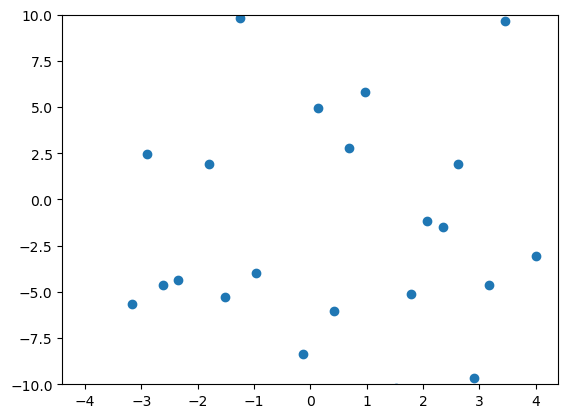

In [34]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
x_grad,y_grad = plot_grad(debut=-4,fin=4,pas=30,n_sim=3,x_data=x_data)
plt.scatter(x_grad,y_grad)
plt.ylim((-10,10))
plt.plot()

# **5) ESTIMATION GRADIENT IWAE**

CF FORMULE (11) ARTICLE

In [ ]:
def gradient_loglikelihood_gradient_estimator(n_sim, mean, r, x_data, theta):
  w_bar = []      # vecteur qui contient les w_bar_i décrits dans l'équation (4) de l'article
  x = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))
  for i in range(n_sim):
    K = np.random.geometric(r, 1)
    z, z_O, z_E = generate_z(K,x_data)
    q, p, q_O, p_O, q_E, p_E = generate_q_p(K,mean,x_data,z,z_O,z_E)
    w = np.log(p) - np.log(q)
  for i in range(len(w)):
    w_bar[i] = n.exp(w[i]) / np.sum(np.exp(w))
  IWAE_gradient_estimator = 0
  for i range(len(z)):
    IWAE_gradient_estimator += w_bar[i] * #gradient 